# Bayes PRF: using emcee to do some MCMC 
Load eg data + design matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


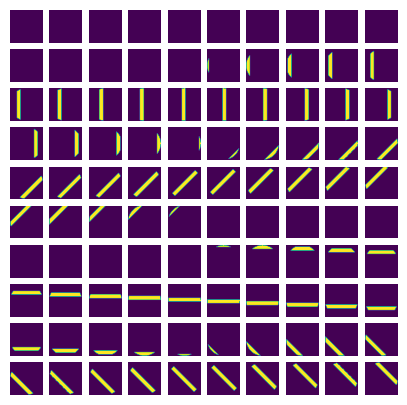

In [70]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
try:
    from prfpy_csenf.stimulus import PRFStimulus2D
    from prfpy_csenf.model import * 
except:
    from prfpy.stimulus import PRFStimulus2D
    from prfpy.model import Iso2DGaussianModel, Norm_Iso2DGaussianModel
from datetime import datetime
from prfpy_bayes.utils import *

# If you already have the design matrix as a numpy array, you can simply load it...
dm = np.load('./design_matrix.npy')

# You can see we have a binarized matrix, of a bar moving across the screen...
fig = plt.figure()
rows = 10
cols = 10
fig.set_size_inches(5,5)
for i in range(100):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.imshow(dm[:,:,i], vmin=0, vmax=1)
    ax.axis('off')
# Now we need to enter the design matrix in a way that prfpy can read it. 
prf_stim = PRFStimulus2D(
    screen_size_cm=39.3,          # Distance of screen to eye
    screen_distance_cm=196,  # height of the screen (i.e., the diameter of the stimulated region)
    design_matrix=dm,                                   # dm (npix x npix x time_points)
    TR=1.5,                                  # TR
    )
# Now we can make the model
g_model = Iso2DGaussianModel(stimulus=prf_stim, hrf=[1, 4.6, 0], normalize_RFs=True)
css_model = CSS_Iso2DGaussianModel(stimulus=prf_stim, hrf=[1, 4.6, 0], normalize_RFs=True)
dn_model = Norm_Iso2DGaussianModel(stimulus=prf_stim, hrf=[1, 4.6, 0], normalize_RFs=True)

# Data
psc_runs = np.load('eg_data.npy')

# Example 1. HRF and gaussian model
Can we capture dependence between HRF and size in gaussian model

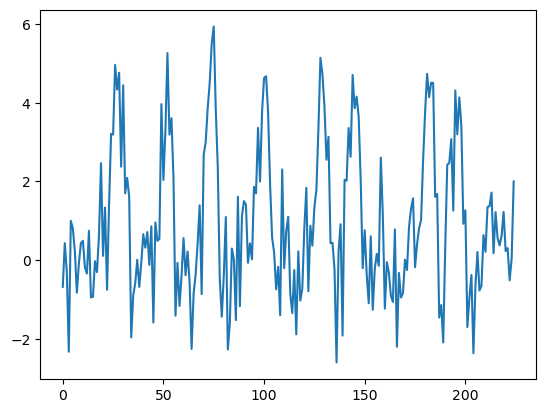

In [74]:
# make fake data
nvx = 100
fake_pars  = {
    'x' : np.random.uniform(-3, 3, nvx),
    'y' : np.random.uniform(-3, 3, nvx),
    'size_1' : np.random.uniform(0.5, 2, nvx),
    'amp_1' : np.ones(nvx),
    'bold_baseline' : np.zeros(nvx),
    'n' : np.random.uniform(0.5, 2, nvx),
    'hrf_deriv' : np.random.uniform(1, 3, nvx),
    'hrf_disp' : np.zeros(nvx),
}
fake_data = css_model.return_prediction(
    *list(fake_pars.values())

)
# Normalize to 5
factor = 5/np.max(fake_data, axis=-1)
fake_pars['amp_1'] *= factor
fake_data = css_model.return_prediction(
    *list(fake_pars.values())
)


fake_data = fake_data + np.random.randn(*fake_data.shape)

plt.plot(fake_data[0,:])

In [54]:
from prfpy_bayes.prf_bayes import *
# Start by making the bprf objects
Gbprf = BayesPRF(
    prf_params=None, # We could put in our best guess here, but we will let the model figure it out...
    model = 'gauss',
    prfpy_model=g_model,
    real_ts=fake_data,
    beta_method='glm', # We are going to use the glm method to estimate the betas (not inside the MCMC)
    fixed_baseline=0, # We are not going to fit the baseline
    )



prf_params.shape[-1]=8
include hrf = True
include rsq = True


In [55]:

bounds = {
    'x': [-5, 5],
    'y': [-5, 5],
    'size_1': [0.1, 10],
    'amp_1': [1, 1],
    'bold_baseline': [0, 0],
    'hrf_deriv' : [0, 5],
    'hrf_disp' : [0, 0],
}
# Uniform prior, based on bounds 
Gbprf.add_priors_from_bounds(bounds)
# Get everything ready...
Gbprf.prep_info()

# Let start with a single voxel
initial_guess = [
    0, # x
    0, # y
    1, # size
    # 1, # amplitude
    4.6, # hrf_deriv
    # 0, # hrf_disp
]
# which timeseries to fit
idx = 0

# Use the multiprocessing pool -> to speed things up
import multiprocessing
# Quick check, how many cpus do we have?
print(f"Number of cpus: {multiprocessing.cpu_count()}")
n_cpus = 20 # I'm using 14 for speeeed!

idx = 0 # Index of the vertex times series to fit
n_steps = 10
n_walkers = 20
time_start = datetime.now()
with multiprocessing.Pool(n_cpus) as pool:
    # We need to set the model for the global model object
    # this is because parallel processing does not allow for the model to be pickled
    # If it doesn't work the first time, try again... 
    # for some reason this is not always working the first time...

    prfpy_global_model.set_model(g_model)
    Gbprf.run_mcmc_fit(
        initial_guess=initial_guess,
        idx=idx, 
        n_walkers=n_walkers,
        n_steps=n_steps, 
        pool=pool, 
        eps=.1,
        # What to save? 
        # we fit alot of stuff...
        # burn_in=500,        # Remove the first n steps as burn in 
        save_top_kpsc=None,   # Save the top k% of fits? [None for all] 
        save_min_rsq=None,     # Minimum rsq to save?  [None for all]
        save_mode='obj',    # Save mode (obj or minimal). Obj saves the whole object, minimal just the parameters        


    )
time_end = datetime.now()
print(f"Time taken: {time_end - time_start}")    

Number of cpus: 48


Initialising walkers for voxel 0 using method: gauss_ball
(20, 4)
Running in parallel
prf_params.shape[-1]=8
include hrf = True
include rsq = True
Time taken: 0:00:01.469831


In [ ]:

bounds = {
    'x': [-5, 5],
    'y': [-5, 5],
    'size_1': [0.1, 10],
    'amp_1': [1, 1],
    'bold_baseline': [0, 0],
    'hrf_deriv' : [0, 5],
    'hrf_disp' : [0, 0],
}
# Uniform prior, based on bounds 
Gbprf.add_priors_from_bounds(bounds)
# Get everything ready...
Gbprf.prep_info()

# Let start with a single voxel
initial_guess = [
    0, # x
    0, # y
    1, # size
    # 1, # amplitude
    4.6, # hrf_deriv
    # 0, # hrf_disp
]
# which timeseries to fit
idx = 0

# Use the multiprocessing pool -> to speed things up
import multiprocessing
# Quick check, how many cpus do we have?
print(f"Number of cpus: {multiprocessing.cpu_count()}")
n_cpus = 20 # I'm using 14 for speeeed!

idx = 0 # Index of the vertex times series to fit
n_steps = 500
n_walkers = 20
import emcee 
moves = emcee.moves.DESnookerMove() # cov sets the step size
moves = [
    # (emcee.moves.StretchMove(), 1),
    # (emcee.moves.DESnookerMove()),
    # emcee.moves.GaussianMove(.0001),
]
time_start = datetime.now()
with multiprocessing.Pool(n_cpus) as pool:
    # We need to set the model for the global model object
    # this is because parallel processing does not allow for the model to be pickled
    # If it doesn't work the first time, try again... 
    # for some reason this is not always working the first time...

    prfpy_global_model.set_model(g_model)
    Gbprf.run_mcmc_fit(
        initial_guess=initial_guess,
        idx=idx, 
        n_walkers=n_walkers,
        n_steps=n_steps, 
        pool=pool, 
        eps=.1,
        # What to save? 
        # we fit alot of stuff...
        # burn_in=500,        # Remove the first n steps as burn in 
        save_top_kpsc=None,   # Save the top k% of fits? [None for all] 
        save_min_rsq=None,     # Minimum rsq to save?  [None for all]
        save_mode='obj',    # Save mode (obj or minimal). Obj saves the whole object, minimal just the parameters        
        kwargs_sampler={'moves':moves}


    )
time_end = datetime.now()
print(f"Time taken: {time_end - time_start}")    

Number of cpus: 48
Initialising walkers for voxel 0 using method: gauss_ball
(20, 4)
Running in parallel
prf_params.shape[-1]=8
include hrf = True
include rsq = True
Time taken: 0:01:05.113730


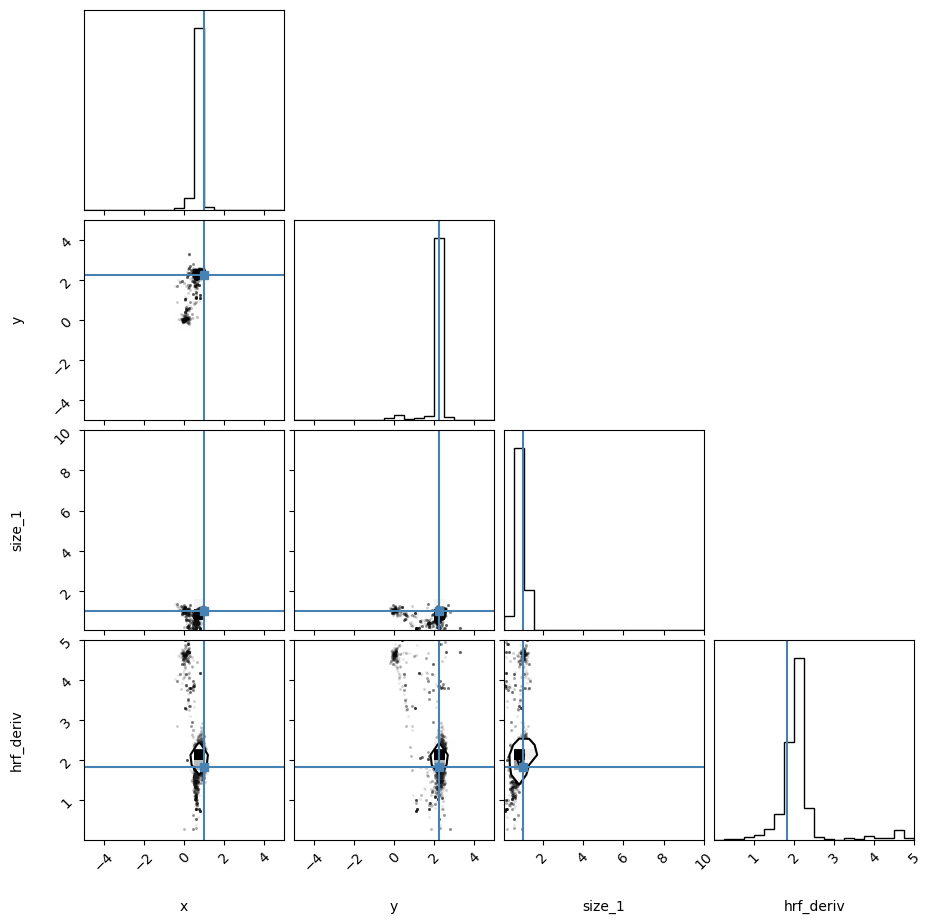

In [68]:
# Corner plot showing
import corner

ps2plot = Gbprf.fit_p_list # + ['rsq']

ps = Gbprf.sampler[idx].return_th_params(
    ps2plot,
    th={'min-step_id':0},
)
_ = corner.corner(
    ps, 
    labels=ps2plot,
    truths=[fake_pars[p][idx] for p in ps2plot],
    range=[bounds[p] for p in ps2plot],
    )


In [40]:
ps

{'x': array([2.25255743, 2.26168176, 2.25674002, ..., 2.38224824, 2.25700177,
        2.36283531]),
 'y': array([-2.03350661, -2.12194704, -2.10362008, ..., -2.00503178,
        -2.04319276, -2.06167183]),
 'size_1': array([1.236066  , 1.16232815, 1.01450454, ..., 1.41918002, 1.17838867,
        1.1670647 ]),
 'hrf_deriv': array([1.36276495, 0.79097355, 0.78602538, ..., 1.36622596, 0.79573251,
        1.673773  ]),
 'hrf_disp': array([2.48832173, 0.97256202, 0.49729084, ..., 3.09098481, 1.6969264 ,
        2.53432178])}

In [36]:
fake_pars

{'x': array([ 2.50324659,  2.45860028, -1.92009784,  0.90940302,  2.25191374,
        -2.27595618, -1.5206831 ,  0.55090722,  1.95650429, -1.32078892,
         2.64822063,  1.48194474, -1.09572558,  1.22045748,  0.00526189,
         0.0861145 ,  2.83905463,  1.07529866, -0.07221942,  0.49790932,
        -0.61850191, -0.65974257, -0.79935368, -0.77083768, -0.02088127,
        -0.16617276,  0.12245415, -2.62500087,  1.57713349, -0.10268453,
         0.07487805,  1.7086734 ,  1.88084195,  1.47521786,  0.4670321 ,
         1.13966164, -1.62082516,  2.19157594,  2.33325999,  2.37146638,
        -2.64905089, -1.6666466 ,  1.93144751,  1.14451474,  2.39419877,
        -2.96569165,  0.8325651 ,  0.49782217,  2.48048853, -0.24681267,
         0.13942509,  0.40016562,  1.5271525 , -1.71723259, -1.39640757,
         2.05122071, -1.50285184,  0.371972  ,  2.16508068,  2.0611623 ,
         1.2431907 , -2.94855819,  1.86691927, -2.90589281,  0.04540445,
        -0.45386098, -0.43299712,  2.89585261,

In [30]:
Gbprf.fit_p_list

['x', 'y', 'size_1', 'hrf_deriv', 'hrf_disp']

In [44]:
plt.plot(psc_runs[100,:
                ])

IndexError: index 100 is out of bounds for axis 0 with size 100

In [28]:
gid0 = Gbprf.sampler[idx]

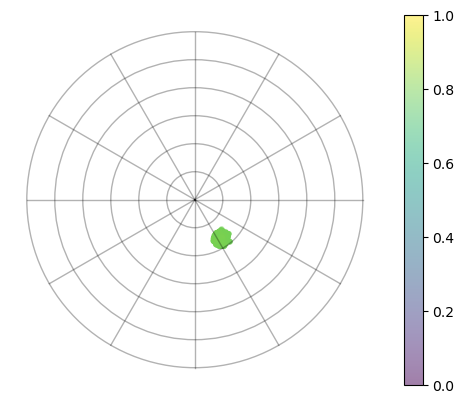

In [30]:
# Lets plot our samples around the visual field 
Gbprf.sampler[idx].visual_field(
    dot_col='rsq',      # Color by r squared
    th={'min-step_id':250},              # No threshold
    do_colbar=True,
    dot_vmin=0,    dot_vmax=1,   
    dot_size=10,
)

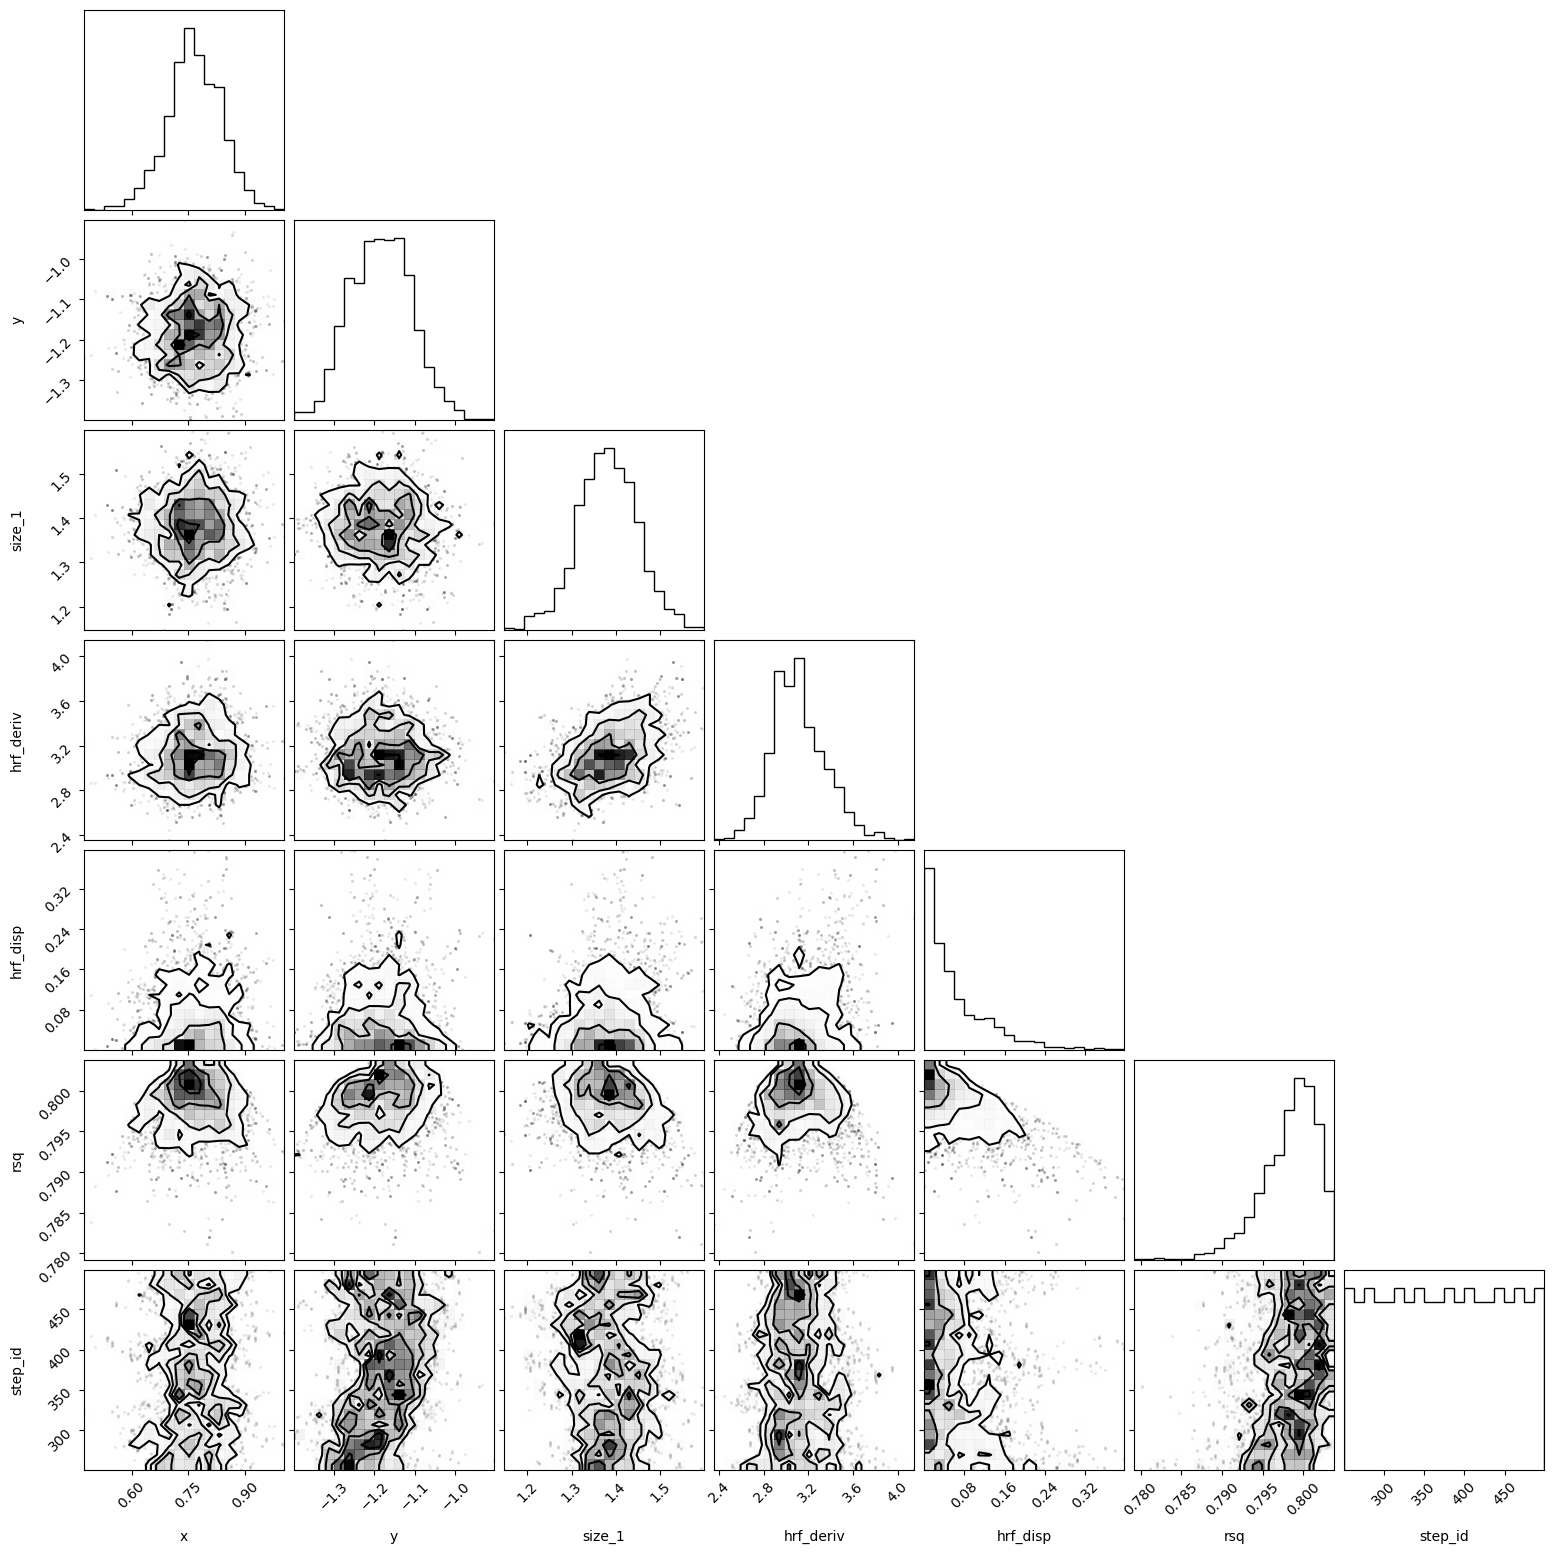

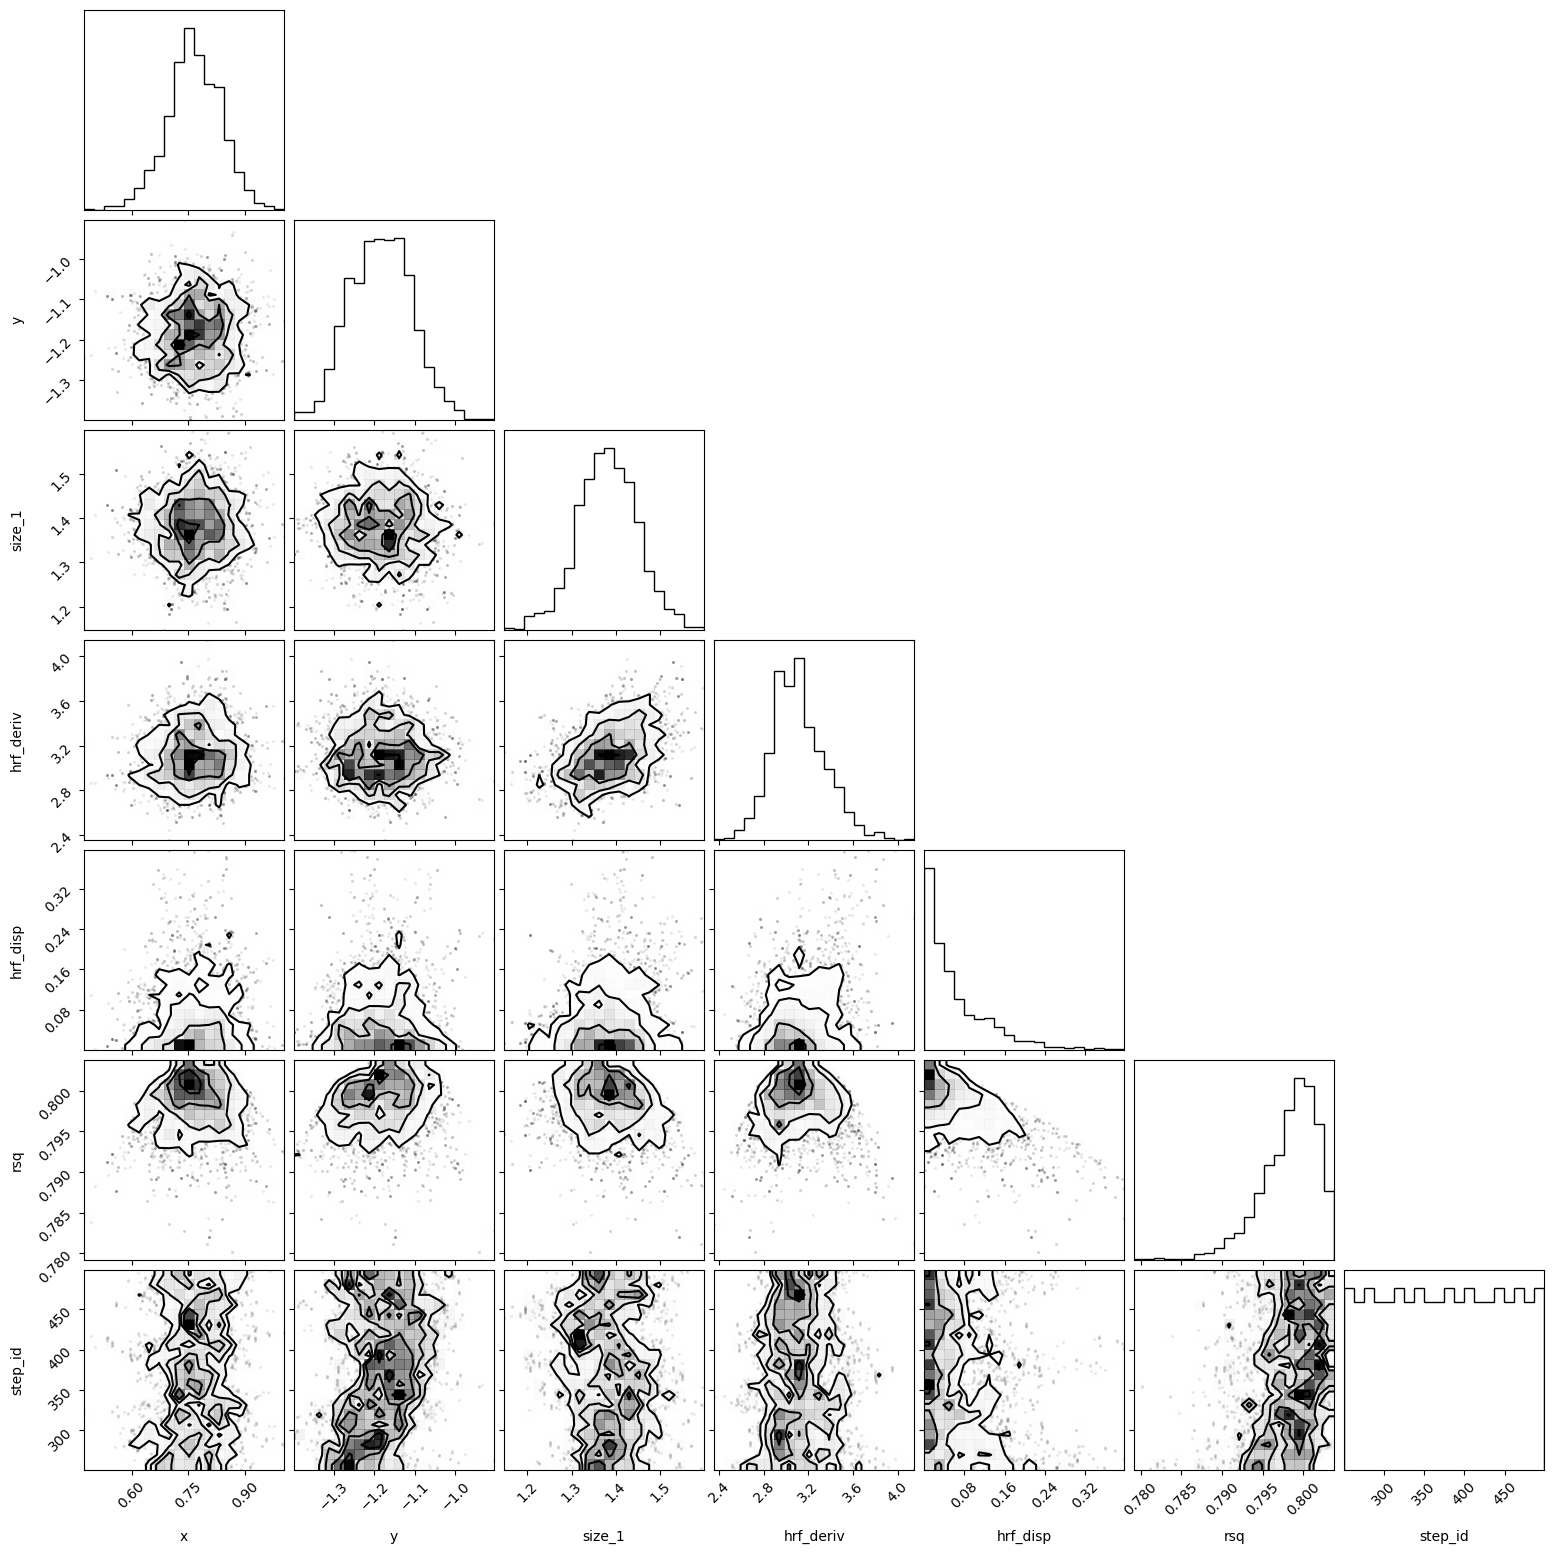

In [39]:
import corner
import pandas as pd
ps = Gbprf.sampler[idx].return_th_params(
    ['x', 'y', 'size_1', 'hrf_deriv', 'hrf_disp',  'rsq', 'step_id'],
    th={'min-step_id':250},
)
corner.corner(
    pd.DataFrame(ps),
    # range=[
    #     (-5, 5),
    #     (-5, 5),
    #     (0, 10),
    #     (0, 10),
    #     (0, 10),
    #     (0, 1),
    #     (250, n_steps),
    # ],
)

71532


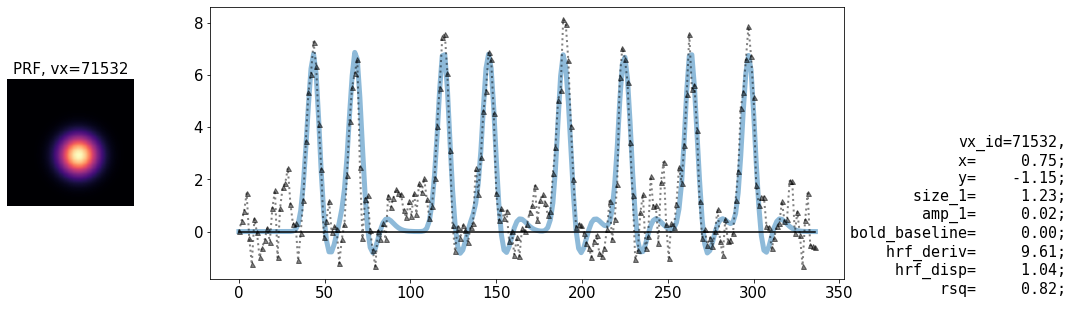

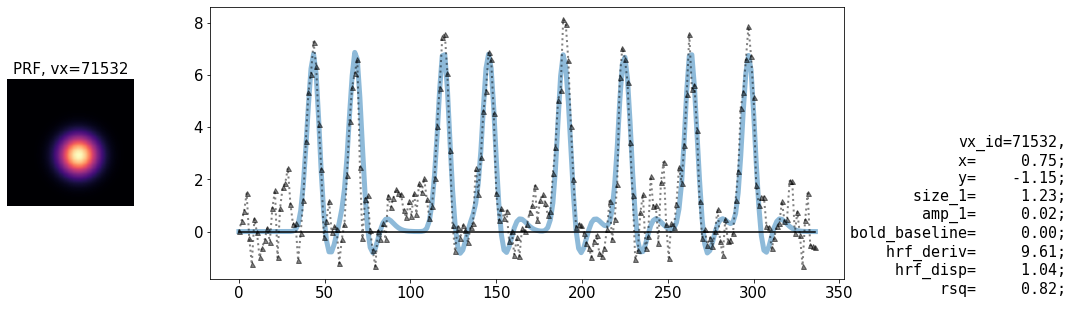

In [12]:
print(Gbprf.sampler[idx].pd_params.rsq.argmax())
Gbprf.sampler[idx].prf_ts_plot(71532)

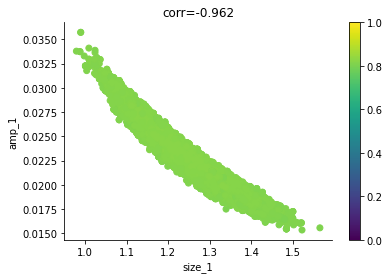

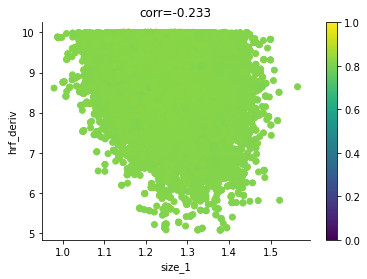

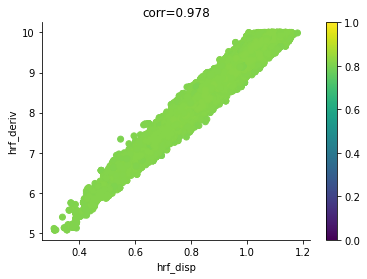

In [14]:
# Can we use this to look at some of the correlation structure in the parameters?
# -> i.e. which parameters can trade off against each other?
burn_in = 500

# For example size and amplitude
Gbprf.sampler[idx].scatter(
    px='size_1', py='amp_1',pc='rsq',
    vmin=0,vmax=1, 
    th={
        'min-step_id' : burn_in, # Only include samples after burn in time point. 
        'min-rsq' : 0, # Only rsq > 0
    },
    do_colbar=True, 
    do_corr=True, 
)

# What about size and hrf_deriv?
plt.figure()
Gbprf.sampler[idx].scatter(
    px='size_1', py='hrf_deriv',pc='rsq',
    vmin=0,vmax=1, 
    th={
        'min-step_id' : burn_in, # Only include samples after burn in time point. 
        'min-rsq' : 0, # Only rsq > 0
    },
    do_colbar=True, 
    do_corr=True, 
)

# What about size and hrf_disp?
plt.figure()
Gbprf.sampler[idx].scatter(
    px='hrf_disp', py='hrf_deriv',pc='rsq',
    vmin=0,vmax=1, 
    th={
        'min-step_id' : burn_in, # Only include samples after burn in time point. 
        'min-rsq' : 0, # Only rsq > 0
    },
    do_colbar=True, 
    do_corr=True, 
)


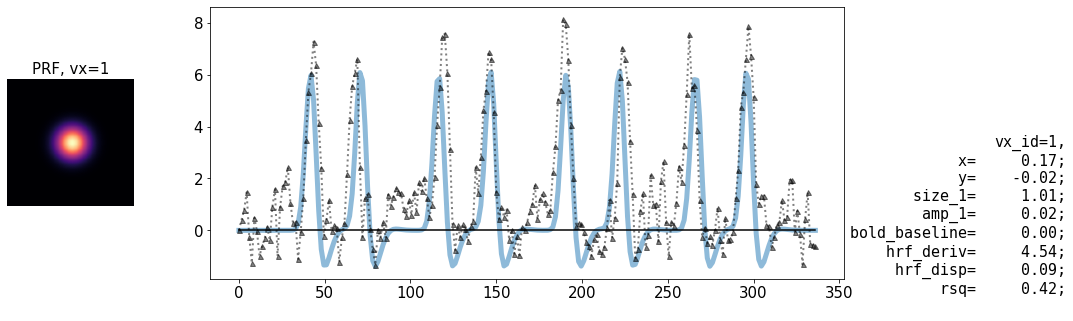

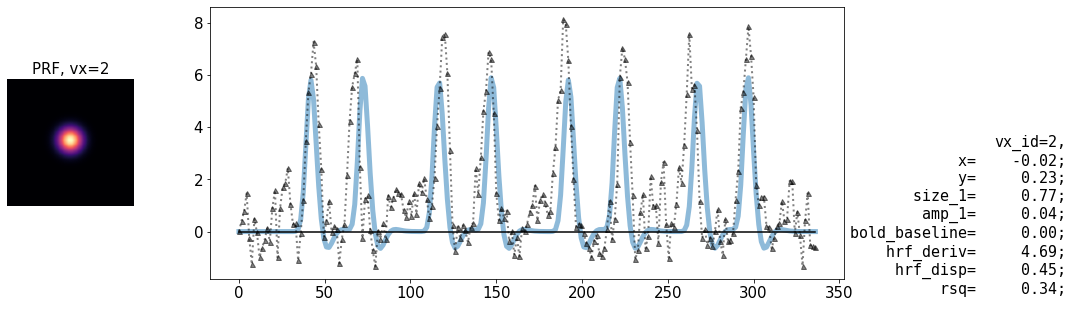

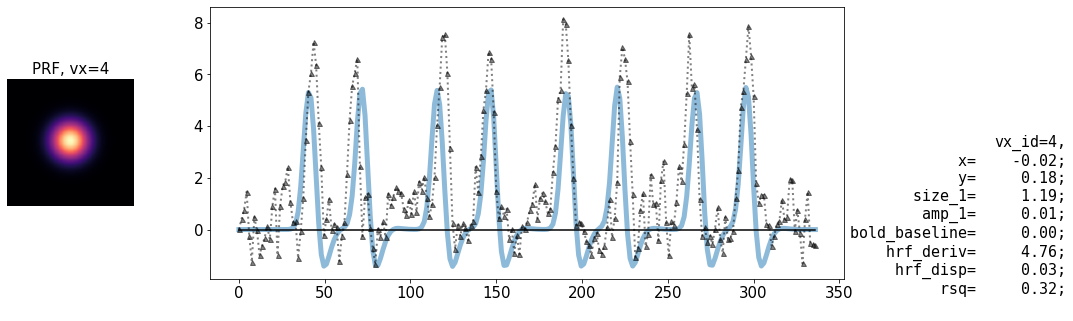

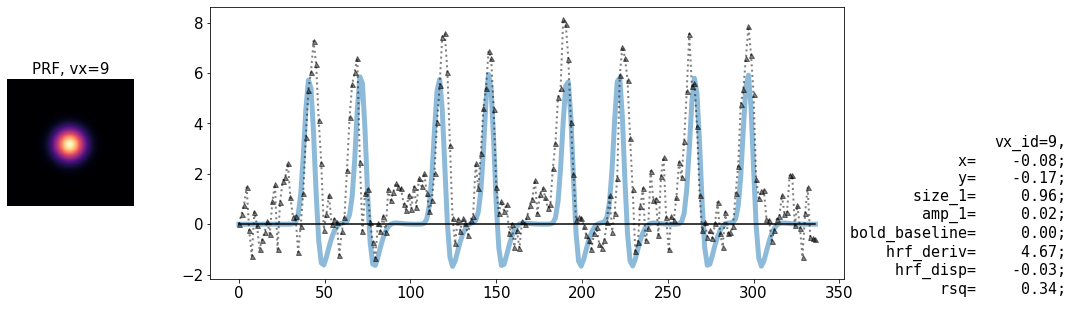

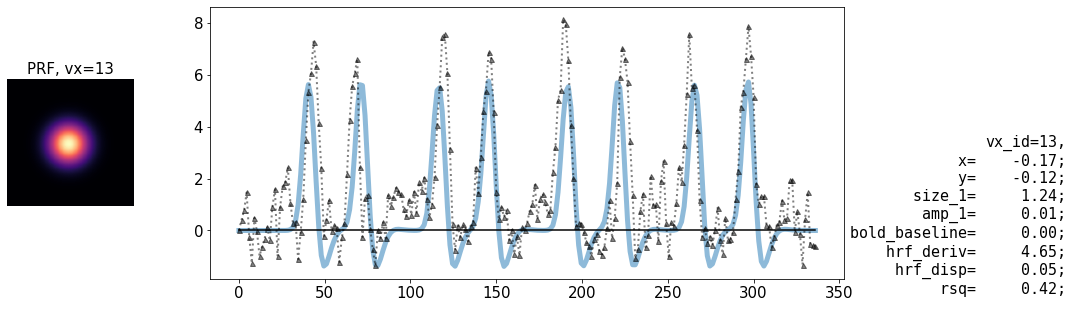

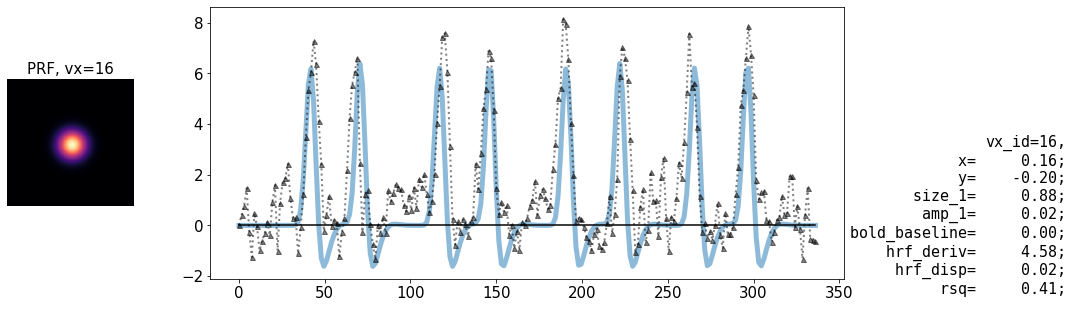

In [15]:
# Ok that was interesting. 
# Lets look at some time series! Ideally where parameters differ, so we can see this tradeoff type thing
good_fits = np.where(Gbprf.sampler[idx].pd_params['rsq'] > 0.3)[0]
plot_eg = 0
size_previous = -100
for i in good_fits:
    size_current = Gbprf.sampler[idx].pd_params['size_1'][i]
    if np.abs(size_current - size_previous) < 0.2:
        continue
    else:
        # Plot it if the size is different enough!!
        size_previous = size_current
        _ = Gbprf.sampler[idx].prf_ts_plot(i)
        plot_eg += 1
    if plot_eg > 5:
        break
        
    

# DN - same again but with the divisive normalisation model!

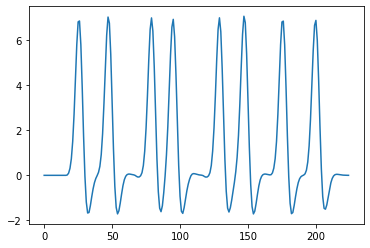

In [174]:
# Fake some data
fake_params = np.array([ -1, -1,  1.36,  4.8, 0,  .4,  3.42,  0.2,
        3.16,  4.6,  0])
fake_ts = dn_model.return_prediction(
    *list(fake_params),
    )
plt.plot(fake_ts.T)

In [95]:
from pfa_scripts.load_saved_info import *
from dag_prf_utils.prfpy_ts_plotter import TSPlotter

psc = load_data_tc('sub-01', 'AS0', )['AS0']
prfpy_stim = get_prfpy_stim('sub-01', 'AS0')['AS0']
dn_model = Norm_Iso2DGaussianModel(stimulus=prfpy_stim, hrf=[1, 4.6, 0])
prf = TSPlotter(
    load_data_prf('sub-01', 'AS0', 'norm')['AS0']['norm'],
    model='norm',
    real_ts=psc,
    prfpy_model=dn_model,
)

/data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/prf_no_hrf/sub-01/ses-1/sub-01_model-gauss_roi-all_task-AS0-fits_stage-iter_constr-tc_desc-prf_params.pkl
/data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/prf_no_hrf/sub-01/ses-1/sub-01_model-norm_roi-all_task-AS0-fits_stage-iter_constr-tc_desc-prf_params.pkl
prf_params.shape[-1]=12
include hrf = True
include rsq = True


In [132]:
vx_mask = prf.return_vx_mask({
    'min-rsq':.1, 
    'min-size_1':0.1,
    'min-b_val' : 200, 
}    
)
print(np.where(vx_mask)[0])

[   123    169    181 ... 542745 600125 615735]


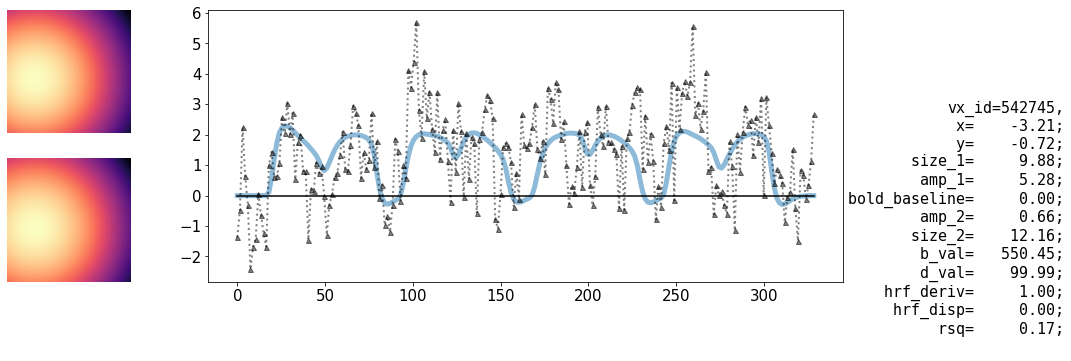

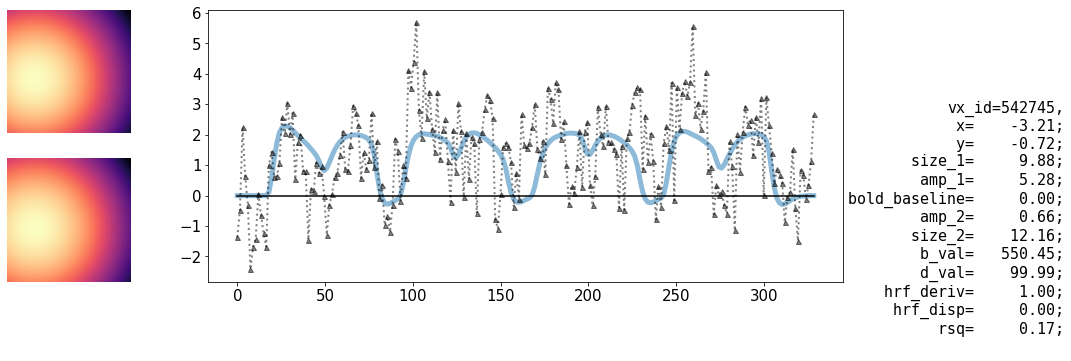

In [144]:
prf.prf_ts_plot(542745)


In [145]:
from prfpy_bayes.prf_bayes import BayesPRF
# Start by making the bprf objects
Nbprf = BayesPRF(
    prf_params=prf.prf_params_np, # We could put in our best guess here, but we will let the model figure it out...
    model = 'norm',
    prfpy_model=dn_model,
    real_ts=psc, #psc_runs,
    beta_method='glm',
    fixed_baseline=0, 
    )
Nbounds = {
    'x': [-5, 5],
    'y': [-5, 5],
    'size_1': [0.1, 10],
    'amp_1': [0, 10],
    'size_2' : [0.1, 10],
    'amp_2' : [0, 10],
    'b_val' : [0, 10],
    'd_val' : [0, 10],
    'bold_baseline': [0, 0],
    'hrf_deriv' : [1, 1], # Not going to fit the HRF, we have enough to deal with...
    'hrf_disp' : [0, 0],
}

Nbprf.add_priors_from_bounds(Nbounds)
Nbprf.prep_info()
print(Nbprf.init_p_id)

prf_params.shape[-1]=12
include hrf = True
include rsq = True
Warning - amp_1 is being fit in glm and mcmc
{'x': 0, 'y': 1, 'size_1': 2, 'amp_1': 3, 'amp_2': 4, 'size_2': 5, 'b_val': 6, 'd_val': 7}


In [151]:
idx = 542745
initial_guess = [
    0, # x
    0, # y
    1, # size
    # 1, # amp_1
    .1, # amp_2
    1, # size_2
    1, # b_val
    10, # d_val
]
time_start = datetime.now()
with multiprocessing.Pool(n_cpus) as pool:
    # We need to set the model for the global model object
    # this is because parallel processing does not allow for the model to be pickled
    # If it doesn't work the first time, try again... 
    # for some reason this is not always working the first time...

    prfpy_global_model.set_model(dn_model)
    Nbprf.run_mcmc_fit(
        # initial_guess=initial_guess,
        idx=idx, 
        n_walkers=40,
        n_steps=1000, 
        pool=pool, 
        eps=1,
        # What to save?
        # we fit alot of stuff...
        # burn_in=500,        # Remove the first n steps as burn in
        save_top_kpsc=None,   # Save the top k% of fits? [None for all]
        save_min_rsq=None,     # Minimum rsq to save?  [None for all]
        save_mode='obj',    # Save mode (obj or minimal). Obj saves the whole object, minimal just the parameters
        enforce_bounds=True, # Enforce the bounds
    )
time_end = datetime.now()
print(f"Time taken: {time_end - time_start}")

Initialising walkers for voxel 542745 using method: gauss_ball
[ -3.21169503  -0.72298053   9.88432483   5.27811062   0.
   0.66302821  12.15873687 550.45028377  99.98728915   1.
   0.        ]
(11,)
11
x
y
size_1
amp_1
amp_2
size_2
b_val
d_val
Running in parallel
Warning - amp_1 is being fit in glm and mcmc
prf_params.shape[-1]=12
include hrf = True
include rsq = True
Time taken: 0:04:06.640376


In [147]:
mprf = Nbprf.sampler[idx]

16


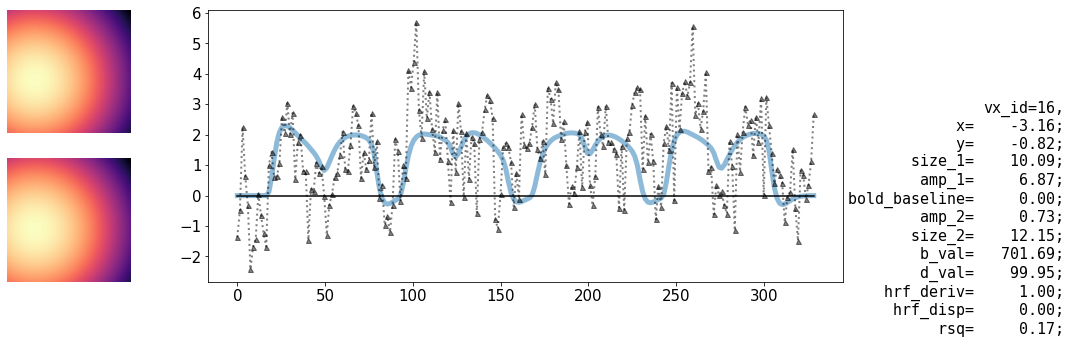

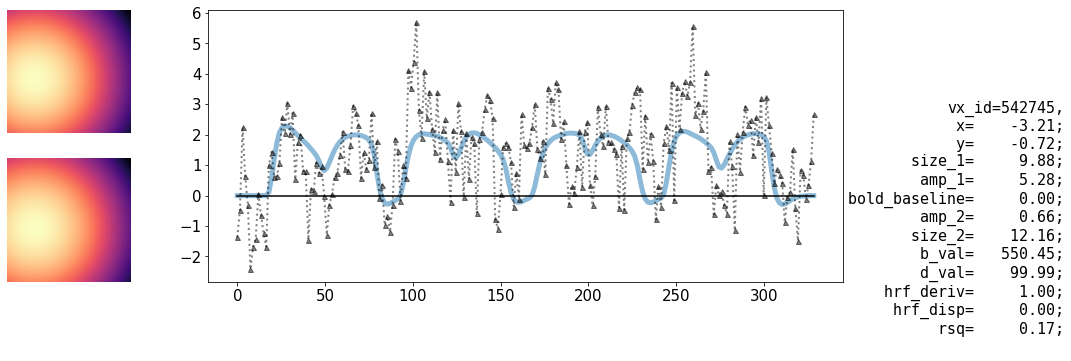

In [149]:
print(mprf.pd_params.rsq.argmax())
_ = mprf.prf_ts_plot(16)
_ = prf.prf_ts_plot(idx)

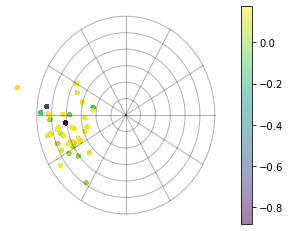

In [152]:
Nbprf.sampler[idx].visual_field(
    dot_col='rsq', 
    th={}, #{'min-step_id':250},
    # th={'min-rsq':.1, }, #'min-step_id':500},
    do_colbar=True,
    # dot_vmin=0, 
    dot_size=10,
)

In [153]:
Nbprf.sampler[idx].pd_params.rsq.max()
# Nbprf.sampler[idx].prf_params_np[36016,:]



0.174049973487854

In [180]:
Nbprf.sampler[idx].pd_params

,x,y,size_1,amp_1,bold_baseline,amp_2,size_2,b_val,d_val,hrf_deriv,...,ecc,pol,clock,size_ratio,amp_ratio,bd_ratio,sup_idx,walker_id,step_id,logprob
0,-1.041116,0.016065,1.466677,-0.013622,0.0,-0.593606,-0.878784,0.026552,9.164535,4.6,...,1.041240,3.126163,8.970531,-0.599167,43.577304,0.002897,0.063921,0,0,-inf
1,1.981331,-0.143802,-0.134060,-14.746931,0.0,-1.076315,1.562495,-9.612928,10.686452,4.6,...,1.986543,-0.072452,2.861628,-11.655220,0.072986,-0.899543,0.100860,1,0,-inf
2,-0.232618,0.476975,-0.355089,0.817704,0.0,0.693568,-0.044115,0.528423,9.120119,4.6,...,0.530675,2.024552,6.866609,0.124237,0.848189,0.057940,76.384138,2,0,-inf
3,-0.399430,0.792612,1.320407,0.039580,0.0,-1.858191,0.089623,0.078253,9.526675,4.6,...,0.887568,2.037593,6.891515,0.067876,-46.947866,0.008214,-4.623359,3,0,-inf
4,-1.139884,0.323730,1.167772,-0.324652,0.0,-0.129536,1.747229,-0.868986,10.017240,4.6,...,1.184963,2.864876,8.471511,1.496207,0.398999,-0.086749,1.119552,4,0,-inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-1.008885,-1.011818,1.075928,7.439820,0.0,0.982070,1.375527,6.837756,8.950446,4.6,...,1.428854,-2.354743,10.502773,1.278457,0.132002,0.763957,4.634978,35,99,97.270142
3996,-0.975822,-1.082194,1.362606,1.743634,0.0,0.164121,2.525617,3.168747,9.133789,4.6,...,1.457179,-2.304554,10.598627,1.853519,0.094126,0.346926,3.092417,36,99,155.222900
3997,-0.956948,-0.856215,0.901259,0.495755,0.0,2.107551,0.145172,0.223632,9.210177,4.6,...,1.284077,-2.411694,10.394004,0.161076,4.251192,0.024281,9.066206,37,99,-217.982178
3998,-1.019104,-0.975739,1.153732,10.253427,0.0,1.330567,1.537372,6.550975,9.266742,4.6,...,1.410901,-2.377930,10.458489,1.332520,0.129768,0.706934,4.339947,38,99,53.893177


In [154]:
vx_mask = np.ones_like(Nbprf.sampler[idx].pd_params.rsq)
print(Nbprf.sampler[idx].pd_params.rsq.argmax())
vx_mask[Nbprf.sampler[idx].pd_params.rsq < 0.7] = 0
# vx_mask[Nbprf.sampler[idx].pd_params.amp_1 < 0] = 0
vx_mask[Nbprf.sampler[idx].pd_params.size_1 > Nbprf.sampler[idx].pd_params.size_2] = 0

id2see = np.where(vx_mask)[0]
old_size2 = -100
for i in id2see[:2400]:
    size2 = Nbprf.sampler[idx].pd_params.size_2[i]
    if np.abs(size2 - old_size2) < 2:
        continue
    else:
        _ = Nbprf.sampler[idx].prf_ts_plot(i)
        old_size2 = size2


26


In [63]:
id2see.shape

(16100,)

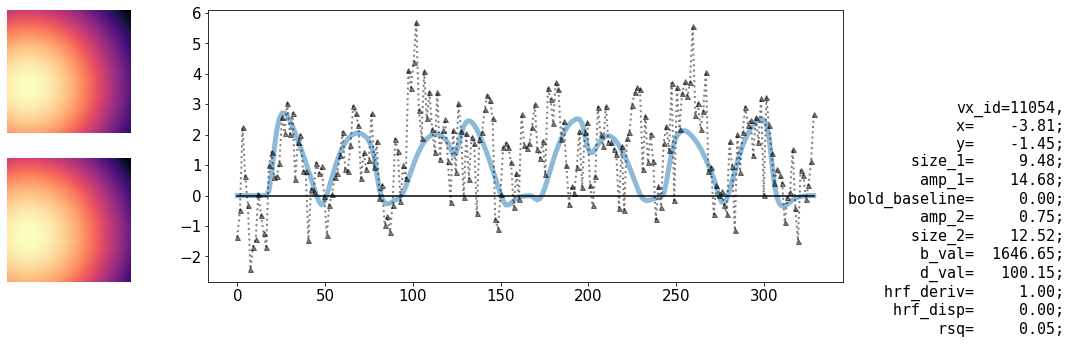

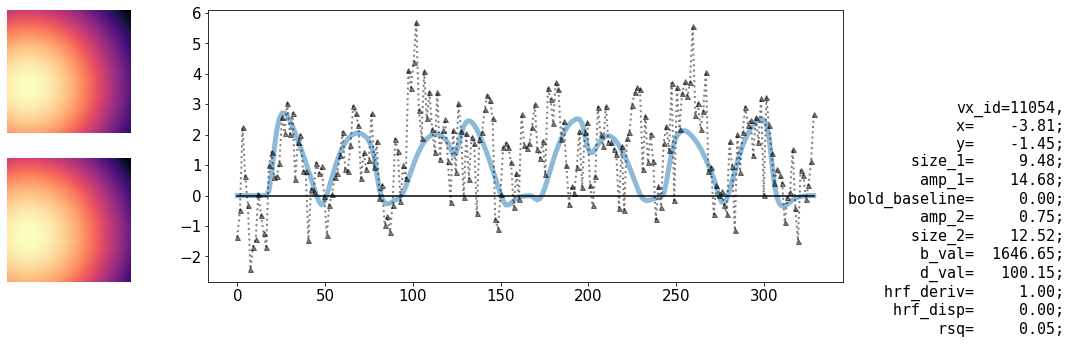

In [155]:
Nbprf.sampler[idx].prf_ts_plot(11054)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

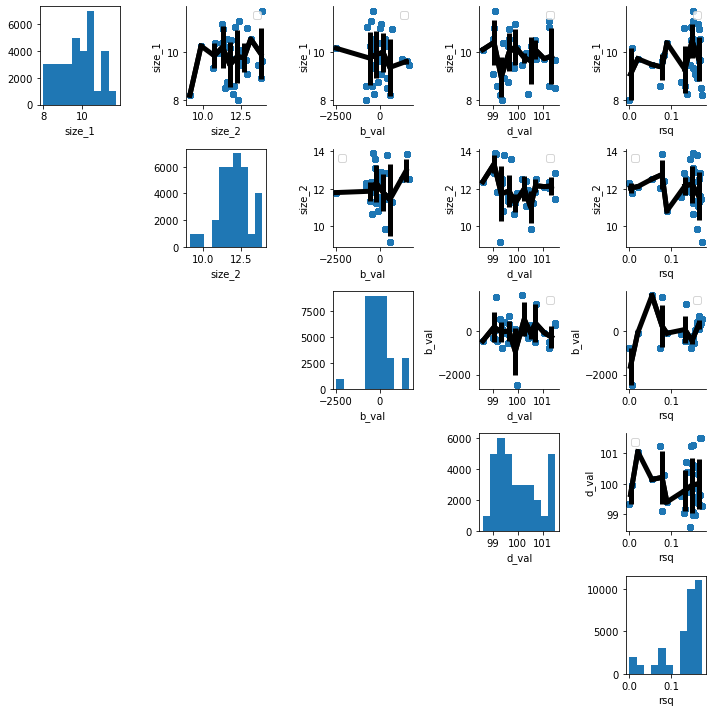

In [158]:
# Multiple scatter for several parameters 
Nbprf.sampler[idx].multi_scatter(
    ['size_1', 'size_2','b_val', 'd_val', 'rsq'],
    th={'min-rsq':0,}, # 'min-size_ratio':1}, 
    # th={'min-rsq':0.76, 'min-step_id':500, 'min-b_val':0},
    # do_id_line=True, 
    do_line=True, 
    dag_scatter=True, 
    
)
plt.gcf().set_size_inches(10,10)

In [ ]:
print()

In [166]:
np.percentile(Nbprf.sampler[idx].pd_params.rsq, 85)

0.7666400671005249